In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import math

# The ABCD Method Revisited: Correlated Data
By Kyle Pitz

## Introduction

We were introduced to the ABCD method of background estimation in previous labs, with the emphasis on an important feature of the background distribution: the two variables need to be uncorrelated such that a density function $f(x,y)$ can be separated into $g_x(x)h_y(y)$. Without this separation, the ABCD method can't work as intended with accuracy. In this lab, I'll explore how to produce correlated data, how we can decorrelate the data for use in teh ABCD method, and comparing the effectiveness of the ABCD method for correlated and uncorrelated data sets.

## Decorrelation Method: Cholesky Decomposition

To decorrelate our data, I use a method called Cholesky decomposition. The idea behind this is that we can decompose the covariance matrix of our correlated data into a lower triangular matrix, $L$, and the conjugate transpose of $L$. These matrices have the property that, for uncorrelated data, transforming by $L$ gives correlated data with the covariance matrix that is decomposed into $L$ and $L^T$. The reverse process is also possible, where correlated data with a given covariance matrix can be transformed by $L^T$, effectively decorrelating the data. The following function takes a pandas dataframe of correlated data, and returns the transformed uncorrelated data, as well as the matrix responsible for the transformation. numpy.linalg has a built in function for cholesky decomposition, making this a simple task.

In [105]:
def decorrelate(data):
    x = data.iloc[:,0] - data.iloc[:,0].mean()
    y = data.iloc[:,1] - data.iloc[:,1].mean()
    data_centered = pd.DataFrame(np.vstack([x,y]).T, columns = ['x', 'y'])
    cov = data_centered.cov()
    L = np.linalg.cholesky(cov).T
    Linv = np.linalg.inv(L)
    M = np.dot(data, Linv)
    return pd.DataFrame(M, columns = ['x', 'y']), Linv

Let's produce some basic correalted data, using numpy's gaussian normal distribution. The following function simply creates two gaussian samples from numpy.random, and returns a pandas dataframe of correlated data from the two normal distributions.

In [223]:
def measure_norm(size = 10000):
     """Measurement model, return two coupled measurements."""
     n1 = np.random.normal(size=size)
     n2 = np.random.normal(scale=0.5, size=size)
     return pd.DataFrame(np.vstack([n1+n2, n1-n2]).T, columns = ['x', 'y'])

Now that we've set up our function to produce correlated data, let's use it to create a sample of 10000 data points.

In [188]:
n = measure_norm(10000)
n.cov()

,x,y
x,1.288211,0.764772
y,0.764772,1.264731


The covariance matrix of the produced data is certainly correlated. We expect uncorrelated data to have the identity matrix as the covariance matrix, and our data definitely doesn't have that feature.

To decorrelate our data, we simply need to call our function that does this. We'll also check to make sure that our new covariance matrix appears uncorrelated, which should be very close to the identity matrix.

In [189]:
nt, Linv_n = decorrelate(n)
nt.cov()

,x,y
x,1.000000e+00,-6.431055e-17
y,-6.431055e-17,1.000000e+00


We can see that our covariance matrix is essentially unity. Now that we've decorrelated the data, we can plot it to visualize how this process is transforming the data.

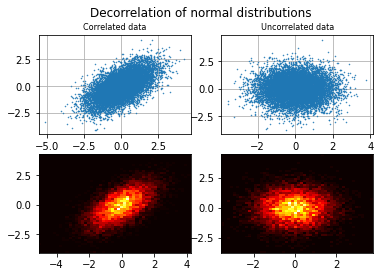

In [190]:
fig, ax = plt.subplots(2,2)
fig.suptitle('Decorrelation of normal distributions', size = 12)
ax[0,0].plot(n1, n2, '.', markersize = 1)
ax[0,0].set_title('Correlated data', size = 8)
ax[0,0].grid()
ax[0,1].plot(nt.x, nt.y,'.', markersize = 1)
ax[0,1].set_title('Uncorrelated data', size = 8)
ax[0,1].grid()
heatmap1 = ax[1,1].hist2d(nt.x, nt.y, bins = (50,50), cmap = plt.cm.hot)
heatmap2 = ax[1,0].hist2d(n1, n2, bins = (50,50), cmap = plt.cm.hot)

Plotting the correlated and uncorrelated data side-by-side allows us to visualize the initial correlation and the transformation that decorrelates the data. Our uncorrelated data certianly looks uncorrelated, it appears to look similar to the standard bivariate normal distribution, with some scaling in either direction.

Let's look a little more closely at what this transformation is doing. In particular, for the ABCD method, we're concerned with how our regions are changing under this transformation. If we define our regions in our uncorrelated data, and then use those same regions on our decorrelated data, our desired sample region might not contain our sample anymore. We can simply create data along the boundaries of our regions, transform it using the same transformation matrix we found in the Cholesky decomposition of the covariance matrix, and plot the transformed data.

In [191]:
xa = np.zeros(2000) + 1
ya = np.zeros(2000) + 1
lin = np.linspace(-3, 3, 2000)
x0 = np.vstack([xa,lin]).T
y0 = np.vstack([lin,ya]).T
xt = np.dot(x0, Linv_n)
yt = np.dot(y0,Linv_n)
lin4 = np.linspace(-4,4,2000)

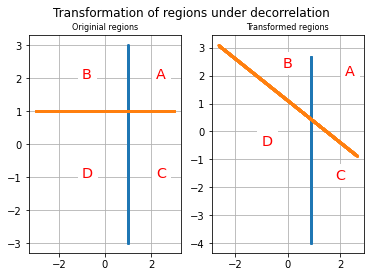

In [192]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Transformation of regions under decorrelation', size = 12)
ax[0].plot(xa, lin, '.', markersize = 3)
ax[0].plot(lin, ya, '.', markersize = 3)
ax[0].text(2.2, 2, 'A', color='r', fontsize='x-large', bbox=dict(color='w', alpha=1.0))
ax[0].text(-1, 2, 'B', color='r', fontsize='x-large', bbox=dict(color='w', alpha=1.0))
ax[0].text(2.2, -1, 'C', color='r', fontsize='x-large', bbox=dict(color='w', alpha=1.0))
ax[0].text(-1, -1, 'D', color='r', fontsize='x-large', bbox=dict(color='w', alpha=1.0))
ax[0].set_title('Originial regions', size = 8)
ax[0].grid()
ax[1].plot(xt[:,0], xt[:,1], '.', markersize = 3)
ax[1].plot(yt[:,0], yt[:,1], '.', markersize = 3)
ax[1].set_title('Transformed regions', size = 8)
ax[1].text(2.2, 2, 'A', color='r', fontsize='x-large', bbox=dict(color='w', alpha=1.0))
ax[1].text(-0.2, 2.3, 'B', color='r', fontsize='x-large', bbox=dict(color='w', alpha=1.0))
ax[1].text(1.8, -1.7, 'C', color='r', fontsize='x-large', bbox=dict(color='w', alpha=1.0))
ax[1].text(-1, -0.5, 'D', color='r', fontsize='x-large', bbox=dict(color='w', alpha=1.0))
ax[1].set_title('Transformed regions', size = 8)
ax[1].grid()
plt.show()

We can see that our decorrelation transformation is doing a combination of rotation and scaling around the origin, making it undesirable to keep the same region boundaries for our decorrelated data. The ABCD method won't work easily with our region boundaries if the lines describing them are functions of both x and y, because when we integrate our pdf our bounds of integration aren't such that we can cancel integrals when taking the ratio of counts in two regions. Therefore, in experimental applications, one should do a similar process like the above to see how the regions transform under the Cholesky decomposition, and redefine the boundaries of their counting regions to make sure the sample region is bounded desirably.

An important note on this transformation: each different data set will have a different decorrelation transformation associated with it, meaning the transformation won't look the same for every data set. This is a case-by-case thing to address and must be treated as such.

Now, let's make a few more correlated distributions to see how our method of decorrelation is working. For now, I'll continue to use distributions in numpy, but later I will consider how we can create our own probability distributions and use those in this process.

The next function uses triangular distributions to produce correlated data.

In [243]:
def measure_tri(size = 10000):
    e1 = np.random.triangular(left = -1, right = 1, mode = 0, size = size)
    e2 = np.random.triangular(left = -3, right = 2, mode = -1.5, size = size)
    return pd.DataFrame(np.vstack([e1+5*e2, 12*e1-e2]).T, columns = ['x', 'y'])

Now to produce the correlated data with this function, then plot the correlated and uncorrelated data.

In [195]:
t = measure_tri(10000)
t_t, Linv_t = decorrelate(t)

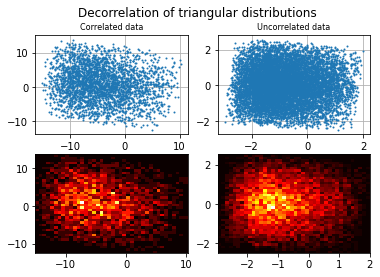

In [196]:
fig, ax = plt.subplots(2,2)
fig.suptitle('Decorrelation of triangular distributions', size = 12)
ax[0,0].plot(t1, t2, '.', markersize = 2)
ax[0,0].set_title('Correlated data', size = 8)
ax[0,0].grid()
ax[0,1].plot(t_t.x, t_t.y,'.', markersize = 2)
ax[0,1].set_title('Uncorrelated data', size = 8)
ax[0,1].grid()
heatmap1 = ax[1,1].hist2d(t_t.x, t_t.y, bins = (40,40), cmap = plt.cm.hot)
heatmap2 = ax[1,0].hist2d(t1, t2, bins = (40,40), cmap = plt.cm.hot)

We can see that the correlated data is visually more subtly correlated. Let's look at the covariace matrices for the correlated and uncorrelated data.

In [197]:
t.cov()

,x,y
x,27.948053,-3.606473
y,-3.606473,24.805624


In [198]:
t_t.cov()

,x,y
x,1.000000e+00,8.172059e-18
y,8.172059e-18,1.000000e+00


Again, we see that the correlated data, t, has a covariance matrix far from the identity; the decorrelated data, t_t, has the identity matrix for its covariance matrix, confirming the data is decorrelated.

Now, I'll show how I've produced data for any desired probability density function, and use the same method to decorrelate the data. This way, I'm no longer restricted to using built-in random variables in numpy or other packages.

# Producing data for any given density function

It is relatively simple to define a desired bivariate density function, like this one.

$P(x,y) = exp\left[-\left(\frac{1}{2} \left(\frac{(x^2 + y^2)-2}{0.4}\right)^2 - \log\left(e^{-0.5\left(\frac{x-2}{0.6}\right
)} + 3e^{-0.5\left(\frac{x-2}{0.6}\right)}\right)\right)\right]$

In [48]:
def density1(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + 3*exp2)
    return np.exp(-u)

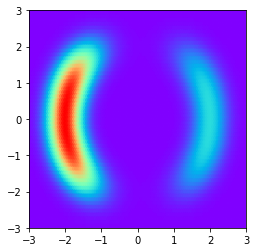

In [84]:
r = np.linspace(-3, 3, 1000)
z = np.array(np.meshgrid(r, r)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

q0 = density1(z)
plt.hexbin(z[:,0], z[:,1], C=q0.squeeze(), cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

Producing random data from a given density function is more challenging than creating the function itself. Initially, my intention was to use inverse transform sampling, in which you input uniformly distributed data in the inverse of the cumulative distribution function of your desired pdf, also called the percent point function. The result of this process gives data that matches your desired pdf. However, in practice you need to be able to calculate the cdf of your pdf, then calculate the inverse of that cdf. scipy has functions that allow you to do these operations for continuous random variables of your choice, but are not well-suited for bivariate distributions. On top of that, when attempting to do so, I encountered countless errors involving integrals not converging enough, defeating the purpose of this method allowing for complex density functions beyond the built-in distributions in numpy or scipy.

Instead of using this inverse transform sampling, I found another method for producing random data from a given distribution, using the Metropolis-Hastings algorithm. Admittedly the specifics underlying proving this algorithm works is beyond my level of understanding, but the general approach is somewhat simple.

The Metropolis-Hastings algorithm is an iterative process to recreate a desired density function, $P(x)$. We choose an arbitrary starting point, $x_t$, and some arbitrary probability density function, $Q(x)$, from which we compute $Q(x_t)$. $Q(x)$ is often referred to as the proposal density, and is used to generate a random walk around each iteration's proposed data point. The idea is that we use the distribution $Q(x'|x)$ to create the next proposed data point, which will be most likely to land near $x$ due to the normal nature of $Q$. For iteration $n$, we pick a candidate $x_n$ from the distribution $Q(x_n|x_t)$, which is centered around the last iteration's candidate point, $x_t$. Then, calculate the acceptance ratio, $\alpha = P(x_n)/P(x_t)$. This ratio represents the probability that this iteration's candidate point, $x_n$, will be accepted or rejected. After generating a random point from a uniform distribution, $u$, we evaluate whether $x_n$ is accepted or rejected. If $\alpha \geq u$, the candidate $x_n$ is accepted, and $x_{t+1} = x_n$. If $\alpha < u$, the candidate is rejected. The quantity $\alpha$ intuitively makes sense because if $P(x_n)/P(x_t)$ is greater than 1, the candidate $x_n$ is more likely to be found from the distribution $P(x)$ than $x_t$ is, which is how we want our random data to behave according to our probability distribution. We are also allowing for probabilistically rejecting data points who are unlikely to be pulled from $P(x)$, when $\alpha$ is less than one.

Because it takes some number of iterations for the random walk to settle into a stable place in our pdf domain, some number of initial iterations are ignored until the random walk is stable.

I will be using code to execute this bivariate Metropolis-Hastings originally found at https://github.com/abdulfatir/sampling-methods-numpy/blob/master/Metropolis-Hastings.ipynb.

In [310]:
def metropolis_hastings(target_density, size=100000):
    burnin_size = 10000
    size += burnin_size
    x0 = np.array([[0, 0]])
    xt = x0
    samples = []
    for i in range(size):
        xt_candidate = np.array([np.random.multivariate_normal(xt[0], np.eye(2))])
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    samples = np.reshape(samples, [samples.shape[0], 2])
    return pd.DataFrame(samples, columns = ['x', 'y'])

This function will take a given pdf as the input target_density, and output a pandas dataframe of samples that reflect the target density function. It uses 10000 "burn-in" iterations that are used to stabilize, which are not used in the returned sample.

Another thing to note about this Metropolis-Hastings algorithm: the input density function need not be properly normalized, like a pdf should be. Because we are taking the ratio of $P(x_n)/P(x_t)$, the normalization factors cancel out and we are still able to produce the sampled data.

Now, I can create various bivariate density functions of any complexity and be able to produce random data from that density function. I'll create a few arbitrary pdf's that I simply created at random. 

To create random sampled data using the Metropolis-Hastings algorithm, using the density function above:

In [311]:
samples = metropolis_hastings(density1, 500000)

Now to plot this sampled data.

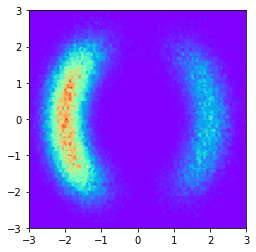

In [312]:
plt.hexbin(samples.x, samples.y, cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

We can see visually that it is reproducing data according to our desired density function.

Now that we have our sampled data from this density function, we can apply our decorrelation transformation and take a look at the decorrelated data, as well as the covariance matrices of the data sets.

In [313]:
df1_decorr, Linv = decorrelate(samples)

In [314]:
samples.cov()

,x,y
x,2.570145,-0.001312
y,-0.001312,1.398306


In [315]:
df1_decorr.cov()

,x,y
x,1.000000e+00,-5.563561e-18
y,-5.563561e-18,1.000000e+00


We can see that our correlated data is more subtly correlated, but our decorrelated data is clearly decorrelated.

Let's plot the data sets to visualize the transformation.

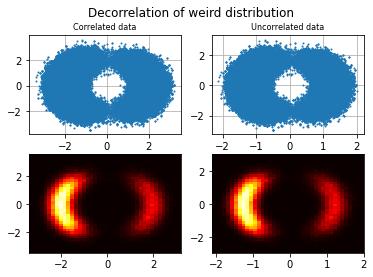

In [316]:
fig, ax = plt.subplots(2,2)
fig.suptitle('Decorrelation of weird distribution', size = 12)
ax[0,0].plot(samples.x, samples.y, '.', markersize = 2)
ax[0,0].set_title('Correlated data', size = 8)
ax[0,0].grid()
ax[0,1].plot(df1_decorr.x, df1_decorr.y,'.', markersize = 2)
ax[0,1].set_title('Uncorrelated data', size = 8)
ax[0,1].grid()
heatmap1 = ax[1,1].hist2d(df1_decorr.x, df1_decorr.y, bins = (40,40), cmap = 'hot')
heatmap2 = ax[1,0].hist2d(samples.x, samples.y, bins = (40,40), cmap = 'hot')

We can see that the transformation is rather simple in this case, our data is mainly being scaled and translated in the horizontal direction. 

Let's try to get an even weirder density function.

In [317]:
def density2(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    u = (1.5 - 3*z1*z2*np.exp(-abs(z1*z2)) + np.exp(-abs(z1)))*np.exp(-np.sqrt(z1**2 + z2**2))/2
    return u

To visualize the distribution:

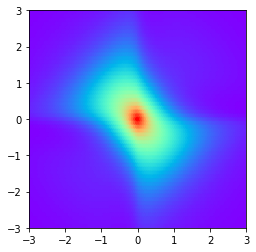

In [318]:
r = np.linspace(-3, 3, 1000)
z = np.array(np.meshgrid(r, r)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

q0 = density2(z)
plt.hexbin(z[:,0], z[:,1], C=q0.squeeze(), cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

Creating sampled data using the Metropolis-Hastings algorithm is again quite simple.

In [319]:
samples2 = metropolis_hastings(density2)

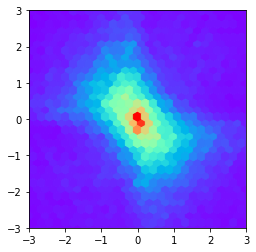

In [320]:
plt.hexbin(samples2.x, samples2.y, cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

In [321]:
samples2.cov()

,x,y
x,2.468181,-0.305676
y,-0.305676,2.953025


In [322]:
samples2_decorr, Linv2 = decorrelate(df2)
samples2_decorr.cov()

,x,y
x,1.000000e+00,8.763852e-17
y,8.763852e-17,1.000000e+00


Again, we see that our decorrelated data has a covariance matrix of the identity.

Plotting the correlated and uncorrelated data side-by-side now,

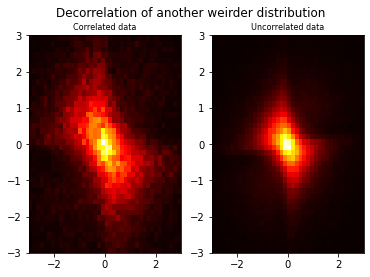

In [323]:
fig, ax = plt.subplots(1,2, sharex = True)
fig.suptitle('Decorrelation of another weirder distribution', size = 12)
ax[0].set_title('Correlated data', size = 8)
ax[1].set_title('Uncorrelated data', size = 8)
heatmap1 = ax[0].hist2d(samples2.x, samples2.y, bins = (40,40), cmap = 'hot', range = ([-3,3],[-3,3]))
heatmap2 = ax[1].hist2d(samples2_decorr.x, samples2_decorr.y, bins = (40,40), cmap = 'hot', range = ([-3,3],[-3,3]))
plt.show()

Here, we can see that the decorrelation transformation is again doing some amount of scaling.

Now that we've created several correlated data sets and decorrelated them, we can get on to actually performing the ABCD method to see how accurate the counting process is.

# Implementing the ABCD Method

I'll first perform the ABCD method on our correlated data sets, to show when and where it fails due to the correlation in our variables.

The next function defines the x and y-values that we split our regions at. Since each data set has different bounds, I had to make the functions very generic, basing the regions on being split 60/40 in the x and y-directions.

In [296]:
def get_regions(data):
    xmin = data.x.min()
    ymin = data.y.min()
    xmax = data.x.max()
    ymax = data.y.max()
    
    x0 = xmin + (xmax - xmin)*0.6
    y0 = ymin + (ymax - ymin)*0.6
    return x0, y0

Once our regions are defined, we can actually start counting data in each region. The next function takes our data as input, uses get_regions to determine the region cutoffs, then counts the data in each region. It returns the difference of true counts and predicted counts in region A, the error.

In [430]:
def count(data):
    x0, y0 = get_regions(data)
    data_above_x0 = data.x > x0
    data_above_y0 = data.y > y0
    A = data_above_x0 & data_above_y0
    B = np.logical_not(data_above_x0) & data_above_y0
    C = data_above_x0 & np.logical_not(data_above_y0)
    D = np.logical_not(data_above_x0) & np.logical_not(data_above_y0)
    counts_A, counts_B, counts_C, counts_D = np.sum(A), np.sum(B), np.sum(C), np.sum(D)
    predicted_A = counts_B*counts_C/counts_D
    return counts_A - predicted_A

We want to run this on many trials of each data set, so the next function repeats the counting process 1000 times for the different data sets and see what the error looks like.

The following function takes the desired distribution function and sample size as its input, creates 10000 data sets from that distribution, performs the counting process to find the error in the ABCD method. It plots a histogram of the errors, and also returns the width of the error distribution normalized by the sample size, and the average Pearson correlation coefficient of each data set.

In [431]:
def error_analysis(distribution, size, num_iter):
    errors = np.zeros(num_iter)
    pearsonr = np.zeros(num_iter)
    for i in range(num_iter):
        data = distribution(size)
        errors[i] = count(data)
        [r,b] = st.pearsonr(data.x, data.y)
        pearsonr[i] = r
    fig = plt.hist(errors, bins = 30, range = (errors.min(), errors.max()))
    xlabel = plt.xlabel('error in ABCD method, counts')
    ylabel = plt.ylabel('frequency of error')
    width = np.std(errors)/size
    ave_error = errors.mean()
    print('Width of gaussian is', width, ', and average Pearson correlation coefficient is', np.mean(pearsonr))
    return width, np.mean(pearsonr), ave_error

Width of gaussian is 0.027305856122752617 , and average Pearson correlation coefficient is 0.6000248758200802


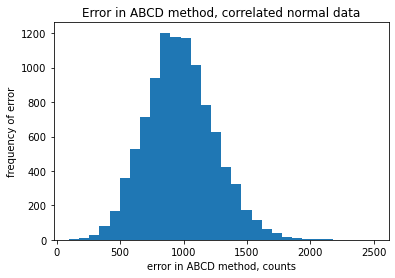

In [432]:
width_n, r_n, ave_error_n = error_analysis(lambda x: measure_norm(), size = 10000, num_iter = 10000)
title = plt.title('Error in ABCD method, correlated normal data')

Width of gaussian is 0.0041753441525771914 , and average Pearson correlation coefficient is -0.1324442157136227


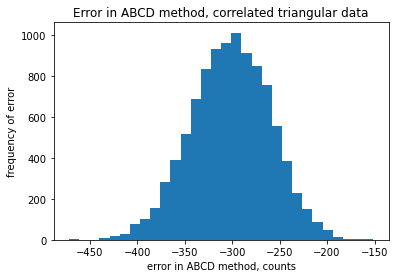

In [433]:
width_tri, r_tri, ave_error_tri = error_analysis(lambda x: measure_tri(), size = 10000, num_iter = 10000)
title = plt.title('Error in ABCD method, correlated triangular data')

We can see that the normal correlated data is almost an order of magnitude larger in width than the triangular correlated data, showing that the ABCD method is less precise for the normal data than the triangular data. Looking at the average pearson correlation coefficients for each set, the gaussian data has a much larger pearson r than the triangular data. Both error distributions are not centered at zero, but offset by a different amount. For the normal distribution, the ABCD method is underestimating the counts in region A by about 1000, whereas the triangular distribution is being underestimated by about 300 counts.

Let's continue to perform the ABCD method on the other correlated data types we've come up with so far.

Because the Metropolis-Hastings algorithm takes much longer to produce data than our previous data methods, I opted to use smaller sample sizes of 1000 while iterating the error analysis 500 times. Although this isn't ideal, it will still give us an idea of general trends in how the ABCD method performs with correlated data. Given more time and computing power, this could be performed on a larger scale for stronger results.

In [444]:
def error_analysis_mh1():
    errors = np.zeros(500)
    pearsonr = np.zeros(500)
    for i in range(500):
        data = metropolis_hastings(density1, size = 1000)
        errors[i] = count(data)
        [r,b] = st.pearsonr(data.x, data.y)
        pearsonr[i] = r
    fig = plt.hist(errors, bins = 20, range = (-500, 500))
    xlabel = plt.xlabel('error in ABCD method, counts')
    ylabel = plt.ylabel('frequency of error')
    width = np.std(errors)/1000
    ave_error = errors.mean()
    print('Width of gaussian is', width, ', and average Pearson correlation coefficient is', np.mean(pearsonr))
    return width, np.mean(pearsonr), ave_error

Width of gaussian is 0.061834091676743114 , and average Pearson correlation coefficient is 0.00020354550467159948


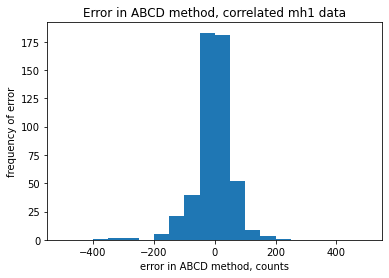

In [445]:
width_mh1, r_mh1, ave_error_mh1 = error_analysis_mh1()
title = plt.title('Error in ABCD method, correlated mh1 data')

In [446]:
def error_analysis_mh2():
    errors = np.zeros(500)
    pearsonr = np.zeros(500)
    for i in range(500):
        data = metropolis_hastings(density2, size = 1000)
        errors[i] = count(data)
        [r,b] = st.pearsonr(data.x, data.y)
        pearsonr[i] = r
    fig = plt.hist(errors, bins = 20, range = (-500, 500))
    xlabel = plt.xlabel('error in ABCD method, counts')
    ylabel = plt.ylabel('frequency of error')
    width = np.std(errors)/1000
    ave_error = errors.mean()
    print('Width of gaussian is', width, ', and average Pearson correlation coefficient is', np.mean(pearsonr))
    return width, np.mean(pearsonr), ave_error

Width of gaussian is 0.08815181743652174 , and average Pearson correlation coefficient is -0.13057323454883413


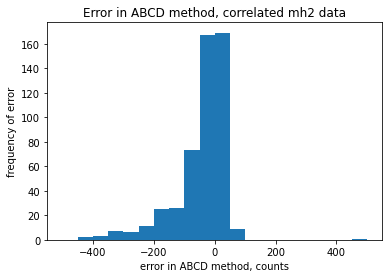

In [447]:
width_mh2, r_mh2, ave_error_mh2 = error_analysis_mh2()
title = plt.title('Error in ABCD method, correlated mh2 data')

Our histograms of errors for the data created by the Metropole-Hastings algorithm look somewhat different from our last two histograms. They are less gausian looking, and much more centered around zero error. Perhaps this is simply a random result of the probability distributions I've used. With more time, we could create many more distributions and see if this pattern continues.

Now let's plot the average error vs. correlation coefficient. Perhaps there is a trend to be seen there.

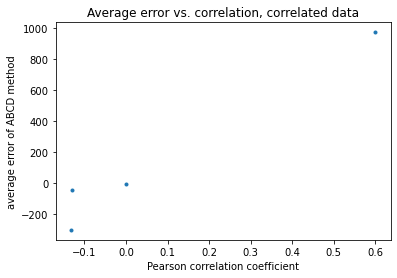

In [452]:
corr = [r_n, r_tri, r_mh1, r_mh2]
ave_errors = [ave_error_n, ave_error_tri, ave_error_mh1, ave_error_mh2]
widths = [width_n, width_tri, width_mh1, width_mh2]
plt.plot(corr, ave_errors, '.')
title = plt.title('Average error vs. correlation, correlated data')
xlabel = plt.xlabel('Pearson correlation coefficient')
ylabel = plt.ylabel('average error of ABCD method')

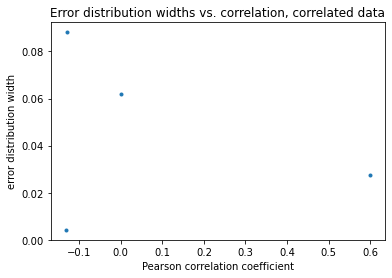

In [453]:
fig = plt.plot(corr, widths, '.')
title = plt.title('Error distribution widths vs. correlation, correlated data')
xlabel = plt.xlabel('Pearson correlation coefficient')
ylabel = plt.ylabel('error distribution width')

These plots aren't particularly useful in seeing obvious trends. With more time and computing power, perhaps including many more distributions of more varying correlations would show some trend. It intuitively makes sense that data sets with larger correlation would perform the worst in the ABCD method, making the error distribution width large.

# Applying ABCD method to decorrelated data

Now that we've seen the ABCD method applied to our decorrelated data, wel'll apply it now to our decorrelated data.

The next function plays the same role as error_analysis, but will decorrelate the data before applying count.

In [454]:
def decorr_error_analysis(distribution, size, num_iter):
    errors = np.zeros(num_iter)
    pearsonr = np.zeros(num_iter)
    for i in range(num_iter):
        data = distribution(size)
        decorr_data, Linv = decorrelate(data)
        errors[i] = count(decorr_data)
        [r,b] = st.pearsonr(decorr_data.x, decorr_data.y)
        pearsonr[i] = r
    fig = plt.hist(errors, bins = 30, range = (errors.min(), errors.max()))
    xlabel = plt.xlabel('error in ABCD method, counts')
    ylabel = plt.ylabel('frequency of error')
    width = np.std(errors)/size
    ave_error = errors.mean()
    print('Width of gaussian is', width, ', and average Pearson correlation coefficient is', np.mean(pearsonr))
    return width, np.mean(pearsonr), ave_error

Width of gaussian is 0.002583124066098226 , and average Pearson correlation coefficient is 1.7958724785049896e-19


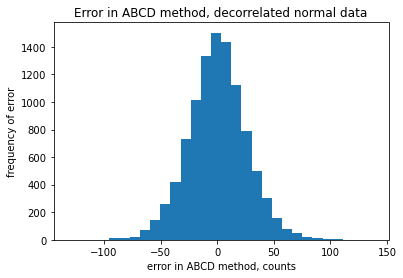

In [455]:
width_n_decorr, r_n_decorr, ave_error_n_decorr = decorr_error_analysis(lambda x: measure_norm(), size = 10000, num_iter = 10000)
title = plt.title('Error in ABCD method, decorrelated normal data')

Width of gaussian is 0.002992701018036174 , and average Pearson correlation coefficient is -4.088119816628155e-19


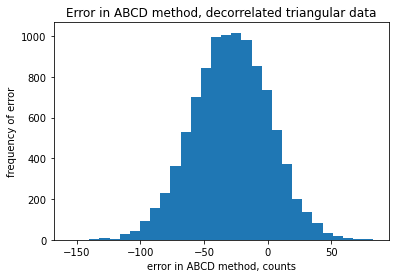

In [456]:
width_tri_decorr, r_tri_decorr, ave_error_tri_decorr = decorr_error_analysis(lambda x: measure_tri(), size = 10000, num_iter = 10000)
title = plt.title('Error in ABCD method, decorrelated triangular data')

In [457]:
def decorr_error_analysis_mh1():
    errors = np.zeros(500)
    pearsonr = np.zeros(500)
    for i in range(500):
        data = metropolis_hastings(density1, size = 1000)
        decorr_data, Linv = decorrelate(data)
        errors[i] = count(decorr_data)
        [r,b] = st.pearsonr(decorr_data.x, decorr_data.y)
        pearsonr[i] = r
    fig = plt.hist(errors, bins = 20, range = (-500, 500))
    xlabel = plt.xlabel('error in ABCD method, counts')
    ylabel = plt.ylabel('frequency of error')
    width = np.std(errors)/1000
    ave_error = errors.mean()
    print('Width of gaussian is', width, ', and average Pearson correlation coefficient is', np.mean(pearsonr))
    return width, np.mean(pearsonr), ave_error

Width of gaussian is 0.027450803931840982 , and average Pearson correlation coefficient is 9.571568124575752e-18


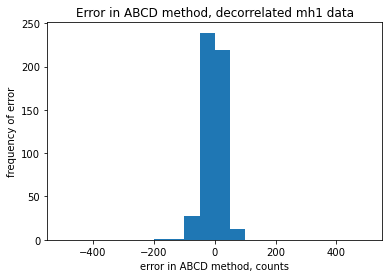

In [458]:
width_mh1_decorr, r_mh1_decorr, ave_error_mh1_decorr = decorr_error_analysis_mh1()
title = plt.title('Error in ABCD method, decorrelated mh1 data')

In [464]:
def decorr_error_analysis_mh2():
    errors = np.zeros(500)
    pearsonr = np.zeros(500)
    for i in range(500):
        data = metropolis_hastings(density2, size = 1000)
        decorr_data, Linv = decorrelate(data)
        errors[i] = count(decorr_data)
        [r,b] = st.pearsonr(decorr_data.x, decorr_data.y)
        pearsonr[i] = r
    fig = plt.hist(errors, bins = 20, range = (-500, 500))
    xlabel = plt.xlabel('error in ABCD method, counts')
    ylabel = plt.ylabel('frequency of error')
    width = np.std(errors)/1000
    ave_error = errors.mean()
    print('Width of gaussian is', width, ', and average Pearson correlation coefficient is', np.mean(pearsonr))
    return width, np.mean(pearsonr), ave_error

Width of gaussian is 0.06688222941991734 , and average Pearson correlation coefficient is 9.276092593981271e-18


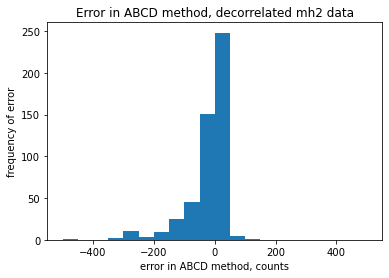

In [465]:
width_mh2_decorr, r_mh2_decorr, ave_error_mh2_decorr = decorr_error_analysis_mh2()
title = plt.title('Error in ABCD method, decorrelated mh2 data')

Next I calculate the percent difference of the widths of the error distributions.

In [466]:
percent_error_n = 100*(width_n - width_n_decorr)/width_n
percent_error_tri = 100*(width_tri - width_tri_decorr)/width_tri
percent_error_mh1 = 100*(width_mh1 - width_mh1_decorr)/width_mh1
percent_error_mh2 = 100*(width_mh2 - width_mh2_decorr)/width_mh2

In [467]:
width_errors = {'Data': ['normal', 'triangular','mh1','mh2'], '% improvement in width of error distribution': [percent_error_n, percent_error_tri, percent_error_mh1, percent_error_mh2]}
width_df = pd.DataFrame(data = width_errors)
width_df

,Data,% improvement in width of error distribution
0,normal,90.540036
1,triangular,28.324447
2,mh1,55.605713
3,mh2,24.128360


The amount by which each data set's error distribution improved in width varies quite largely between data sets. We see the overall trend of improving the precision of errors, with all widths getting smaller after decorrelation, but some data sets performed much better than others. The normal data set improved the most, decreasing the width of the error distribution by over 90% when decorrelated data was used. This may be because it was the data that had the highest average Pearson correlation, giving it a lot of room to improve through decorrelation. We see a comparable improvement in data sets produced from numpy distributions and data produced from the Metropolis-Hastings algorithm, despite the distributions from the M-H algorithm being mathematically more complicated.

This statistic is one of the more important ones in regards to the precision of the ABCD method. We want to be able to get repeatable results, and if our error distribution is very wide the results aren't reliably repeatable. 

The other important statistic in the sucess of the ABCD method is the centers of the error distributions. Let's put them all in a pandas dataframe to view them.

In [471]:
ave_errors = {'Data, correlated': ['normal', 'triangular','mh1','mh2'], 'Average error':[ave_error_n, ave_error_tri, ave_error_mh1, ave_error_mh2]}
ave_error_df = pd.DataFrame(data = ave_errors)
ave_error_df

,"Data, correlated",Average error
0,normal,974.902264
1,triangular,-301.825379
2,mh1,-4.354178
3,mh2,-42.550906


We can see that the correlated data varies widely in the centers of the distributions. Let's see if it improved:

In [472]:
ave_decorr_errors = {'Data, decorrelated': ['normal', 'triangular','mh1','mh2'], 'Average error':[ave_error_n_decorr, ave_error_tri_decorr, ave_error_mh1_decorr, ave_error_mh2_decorr]}
ave_err_decorr = pd.DataFrame(data = ave_decorr_errors)
ave_err_decorr

,"Data, decorrelated",Average error
0,normal,0.253809
1,triangular,-29.016131
2,mh1,-2.868109
3,mh2,-21.334546


We can see that all data sets get much closer to an average error of zero, which is what we want when using the ABCD method. The normal distribution had the most improvement in its average error, and error distribution width improvement also, possibly suggesting that data that is more similar to bivariate normal distributions can be better decorrelated for use in the ABCD method. We would ideally want more data sets of more density distributions to make stronger comments about this, given more time and computing power.

Overall, looking at these statistics, it is clear that, for the given density distributions, this process was able to improve the effectiveness of the ABCD method. Some distributions were more affected than others by this process, showing there isn't a specific amount by which every distribution improves, but is dependent on the distribution in question.